# Random Forest

## Импорт

In [1]:
import warnings


from catboost import CatBoostClassifier

from category_encoders.target_encoder import TargetEncoder

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import (percentileofscore,
                         randint,
                         ttest_ind,
                         uniform,
                        )

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              RandomForestClassifier,
                              VotingClassifier,
                             )

from sklearn.feature_selection import (mutual_info_classif, 
                                       RFE,
                                       RFECV,
                                       SelectKBest,
                                      )

from sklearn.impute import (MissingIndicator, 
                            SimpleImputer,
                           )

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,
                             f1_score,
                             get_scorer, 
                             roc_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )

from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score,
                                     GridSearchCV,
                                     train_test_split,
                                    )

from sklearn.preprocessing import (Binarizer, 
                                   FunctionTransformer, 
                                   KBinsDiscretizer, 
                                   StandardScaler,
                                  )

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost import (plot_importance, 
                     XGBClassifier
                    )


from infographics import *


warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 42
CV = 10


%matplotlib inline

## Загрузка данных

In [2]:
data = pd.read_csv('../datasets/train.csv')

## Разделения на тестовый и тренировочный наборы

In [3]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Обработка данных

### Разработка новых признаков

#### `Title`

In [4]:
def add_title(X, y=None):
    title = X.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?')
    title = pd.Series(title[0], name='Title').str.lower()
    
    title = title.where(title.isin(['mr', 'miss', 'mrs', 'master']), 'aristocratic')
    
    return pd.concat([X, title], axis='columns')

TitleAdder = FunctionTransformer(func=add_title)

#### `AgeGroup` и `FareGroup`

```Python
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
    ('encoder', TargetEncoder(cols=[0, 1])),
])
```

#### `Family`

In [5]:
def add_family(X, y=None):
    family = X.Parch + X.SibSp
    family.name ='Family'

    return pd.concat([X, family], axis='columns')

FamilyAdder = FunctionTransformer(func=add_family)

#### `isFramily`
Для добавления атрибута `isFramily` будем использовать `sklearn.preprocessing.Binarizer`.

#### `Cabin`

In [6]:
def encode_cabin(X, y=None):
    data = X.copy()
    data.Cabin = data.Cabin.str.slice(stop=1)
    data.loc[data.Cabin.isna(), 'Cabin'] = 'unknown'
    
    return data

CabinEncoder = FunctionTransformer(func=encode_cabin)

#### `Ticket`

In [7]:
def encode_ticket(X, y=None):
    data = X.copy()
    counts = data.Ticket.value_counts()
    data.Ticket = data.Ticket.replace(counts)
    
    data.loc[data.Ticket.isna(), 'Ticket'] = -1
    
    return data

TicketEncoder = FunctionTransformer(func=encode_ticket)

### Оценка информативности признаков

#### Конвейер
Создадим конвейер, выполняющий обработку данных.

In [8]:
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),        
])

Попробуем обработать с помощью разработанного конвейера обучающую выборку, преобразовать результат в датафрейм и вывести его первые 5 строк.

In [9]:
cols = [
    'isFamily',
    'Pclass', 
    'Sex', 
    'Embarked', 
    'Title', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 
    'SibSp', 
    'Parch',
    'Family'
]

preprocessed_data = pd.DataFrame(data_prep_target_enc.fit_transform(X_train, y_train), columns=cols)
preprocessed_data.head()

,isFamily,Pclass,Sex,Embarked,Title,Cabin,Ticket,AgeGroup,FareGroup,SibSp,Parch,Family
0,0.0,0.242967,0.185185,0.330116,0.152913,0.291667,0.416666,0.358025,0.603352,-0.465084,-0.466183,-0.556339
1,0.0,0.446667,0.185185,0.330116,0.152913,0.291667,0.317227,0.358025,0.236486,-0.465084,-0.466183,-0.556339
2,0.0,0.649123,0.185185,0.330116,0.152913,0.682927,0.317227,0.358025,0.603352,-0.465084,-0.466183,-0.556339
3,1.0,0.242967,0.743083,0.330116,0.785047,0.291667,0.317227,0.426829,0.252427,-0.465084,0.727782,0.073412
4,1.0,0.446667,0.743083,0.330116,0.785047,0.291667,0.623188,0.358025,0.435754,0.478335,0.727782,0.703162


#### Корреляция между обучающими признаками

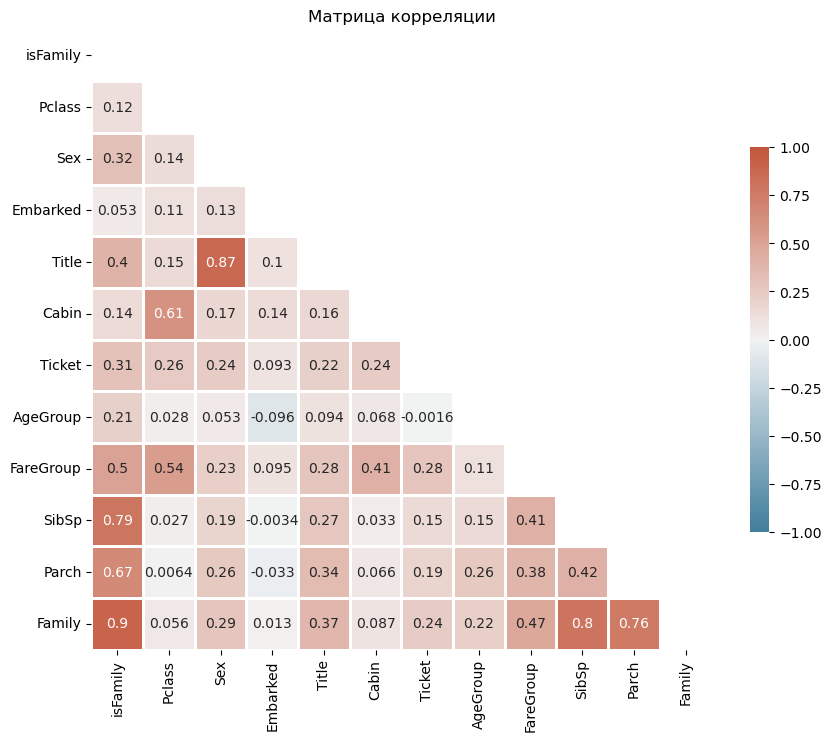

In [10]:
plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(10, 10), method='kendall')

#### Взаимная информация (Mutual Information)

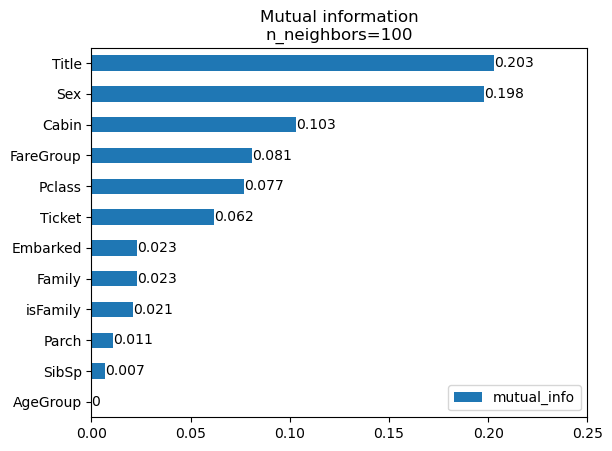

In [11]:
print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);

## Базовая модель

Значения метрик для DummyClassifier


,mean,median,min,max,results_on_train_set
accuracy,0.551906,0.538462,0.514085,0.608392,0.549157
f1,0.364298,0.361905,0.244898,0.465517,0.404372
roc_auc,0.456949,0.453409,0.430766,0.490909,0.495715


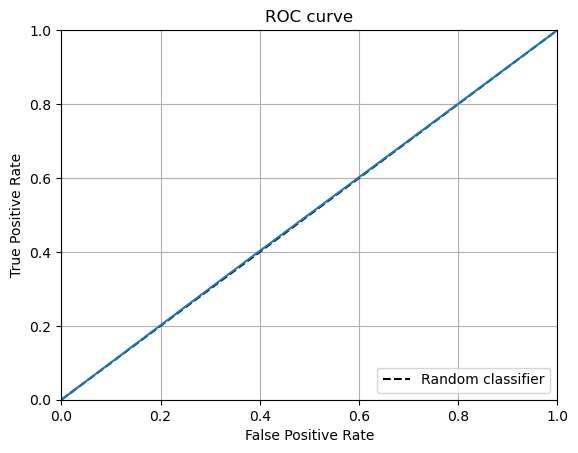

In [12]:
dummy_clf = DummyClassifier(strategy='stratified')

_ = evaluate_model(model=dummy_clf, X=X_train, y=y_train, label='DummyClassifier')

## Random Forest с параметрами по умолчанию

In [13]:
pipe = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),
    
    ('classifier', CatBoostClassifier())
])

pipe

Pipeline(steps=[('title_adder',
                 FunctionTransformer(func=<function add_title at 0x000002247410F130>)),
                ('family_adder',
                 FunctionTransformer(func=<function add_family at 0x000002247410F520>)),
                ('cabin_encoder',
                 FunctionTransformer(func=<function encode_cabin at 0x000002247410F880>)),
                ('ticket_encoder',
                 FunctionTransformer(func=<function encode_ticket at 0x000002247410...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=4)),
                                                                  ('encoder',
                                                                   TargetEncoder(cols=[0,
                                                                                       1]))]),
                                                  ['Age', 'Fare']),
                                                 ('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch',
                                                   'Family'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000224754C7C70>)])

final pipline
Learning rate set to 0.008911
0:	learn: 0.6870611	total: 131ms	remaining: 2m 11s
1:	learn: 0.6812316	total: 133ms	remaining: 1m 6s
2:	learn: 0.6750283	total: 134ms	remaining: 44.6s
3:	learn: 0.6687127	total: 135ms	remaining: 33.7s
4:	learn: 0.6623231	total: 137ms	remaining: 27.2s
5:	learn: 0.6568756	total: 138ms	remaining: 22.9s
6:	learn: 0.6511852	total: 139ms	remaining: 19.8s
7:	learn: 0.6464336	total: 141ms	remaining: 17.5s
8:	learn: 0.6421191	total: 142ms	remaining: 15.7s
9:	learn: 0.6367057	total: 144ms	remaining: 14.2s
10:	learn: 0.6316338	total: 145ms	remaining: 13s
11:	learn: 0.6267194	total: 146ms	remaining: 12s
12:	learn: 0.6221534	total: 148ms	remaining: 11.2s
13:	learn: 0.6182498	total: 149ms	remaining: 10.5s
14:	learn: 0.6138511	total: 150ms	remaining: 9.87s
15:	learn: 0.6092825	total: 152ms	remaining: 9.33s
16:	learn: 0.6062527	total: 153ms	remaining: 8.85s
17:	learn: 0.6011986	total: 155ms	remaining: 8.43s
18:	learn: 0.5984376	total: 156ms	remaining: 8.04s


182:	learn: 0.3751629	total: 385ms	remaining: 1.72s
183:	learn: 0.3745826	total: 386ms	remaining: 1.71s
184:	learn: 0.3741456	total: 388ms	remaining: 1.71s
185:	learn: 0.3738081	total: 390ms	remaining: 1.7s
186:	learn: 0.3734898	total: 391ms	remaining: 1.7s
187:	learn: 0.3730986	total: 393ms	remaining: 1.7s
188:	learn: 0.3725802	total: 394ms	remaining: 1.69s
189:	learn: 0.3720939	total: 396ms	remaining: 1.69s
190:	learn: 0.3717439	total: 397ms	remaining: 1.68s
191:	learn: 0.3713393	total: 399ms	remaining: 1.68s
192:	learn: 0.3710741	total: 401ms	remaining: 1.68s
193:	learn: 0.3708019	total: 402ms	remaining: 1.67s
194:	learn: 0.3701376	total: 404ms	remaining: 1.67s
195:	learn: 0.3697998	total: 405ms	remaining: 1.66s
196:	learn: 0.3694295	total: 406ms	remaining: 1.66s
197:	learn: 0.3690241	total: 408ms	remaining: 1.65s
198:	learn: 0.3686465	total: 409ms	remaining: 1.65s
199:	learn: 0.3682793	total: 411ms	remaining: 1.64s
200:	learn: 0.3678802	total: 412ms	remaining: 1.64s
201:	learn: 0.3

451:	learn: 0.3177247	total: 772ms	remaining: 935ms
452:	learn: 0.3175445	total: 773ms	remaining: 934ms
453:	learn: 0.3173612	total: 775ms	remaining: 932ms
454:	learn: 0.3172201	total: 776ms	remaining: 930ms
455:	learn: 0.3170177	total: 778ms	remaining: 928ms
456:	learn: 0.3169457	total: 779ms	remaining: 926ms
457:	learn: 0.3168446	total: 781ms	remaining: 924ms
458:	learn: 0.3166886	total: 782ms	remaining: 922ms
459:	learn: 0.3165302	total: 784ms	remaining: 920ms
460:	learn: 0.3165105	total: 785ms	remaining: 918ms
461:	learn: 0.3163984	total: 786ms	remaining: 916ms
462:	learn: 0.3162932	total: 788ms	remaining: 914ms
463:	learn: 0.3161713	total: 789ms	remaining: 912ms
464:	learn: 0.3160099	total: 791ms	remaining: 910ms
465:	learn: 0.3157606	total: 792ms	remaining: 908ms
466:	learn: 0.3156668	total: 793ms	remaining: 906ms
467:	learn: 0.3155102	total: 795ms	remaining: 904ms
468:	learn: 0.3153039	total: 796ms	remaining: 902ms
469:	learn: 0.3151689	total: 798ms	remaining: 900ms
470:	learn: 

720:	learn: 0.2879634	total: 1.16s	remaining: 449ms
721:	learn: 0.2878910	total: 1.16s	remaining: 448ms
722:	learn: 0.2877430	total: 1.16s	remaining: 446ms
723:	learn: 0.2876809	total: 1.17s	remaining: 444ms
724:	learn: 0.2876449	total: 1.17s	remaining: 443ms
725:	learn: 0.2875232	total: 1.17s	remaining: 441ms
726:	learn: 0.2874083	total: 1.17s	remaining: 439ms
727:	learn: 0.2872818	total: 1.17s	remaining: 438ms
728:	learn: 0.2871869	total: 1.17s	remaining: 436ms
729:	learn: 0.2870778	total: 1.17s	remaining: 435ms
730:	learn: 0.2869693	total: 1.18s	remaining: 433ms
731:	learn: 0.2868806	total: 1.18s	remaining: 431ms
732:	learn: 0.2867457	total: 1.18s	remaining: 430ms
733:	learn: 0.2866178	total: 1.18s	remaining: 428ms
734:	learn: 0.2865763	total: 1.18s	remaining: 427ms
735:	learn: 0.2865140	total: 1.19s	remaining: 425ms
736:	learn: 0.2864732	total: 1.19s	remaining: 424ms
737:	learn: 0.2864189	total: 1.19s	remaining: 422ms
738:	learn: 0.2863259	total: 1.19s	remaining: 420ms
739:	learn: 

988:	learn: 0.2638556	total: 1.55s	remaining: 17.3ms
989:	learn: 0.2638034	total: 1.56s	remaining: 15.7ms
990:	learn: 0.2637596	total: 1.56s	remaining: 14.1ms
991:	learn: 0.2637219	total: 1.56s	remaining: 12.6ms
992:	learn: 0.2636143	total: 1.56s	remaining: 11ms
993:	learn: 0.2635226	total: 1.56s	remaining: 9.43ms
994:	learn: 0.2634211	total: 1.56s	remaining: 7.86ms
995:	learn: 0.2633657	total: 1.56s	remaining: 6.29ms
996:	learn: 0.2633267	total: 1.57s	remaining: 4.71ms
997:	learn: 0.2632654	total: 1.57s	remaining: 3.14ms
998:	learn: 0.2631523	total: 1.57s	remaining: 1.57ms
999:	learn: 0.2630444	total: 1.57s	remaining: 0us
Learning rate set to 0.008911
0:	learn: 0.6870611	total: 1.37ms	remaining: 1.37s
1:	learn: 0.6812316	total: 2.6ms	remaining: 1.3s
2:	learn: 0.6750283	total: 4.03ms	remaining: 1.34s
3:	learn: 0.6687127	total: 5.33ms	remaining: 1.33s
4:	learn: 0.6623231	total: 6.68ms	remaining: 1.33s
5:	learn: 0.6568756	total: 7.99ms	remaining: 1.32s
6:	learn: 0.6511852	total: 9.27ms	r

284:	learn: 0.3462272	total: 394ms	remaining: 988ms
285:	learn: 0.3461067	total: 395ms	remaining: 987ms
286:	learn: 0.3458997	total: 397ms	remaining: 986ms
287:	learn: 0.3454666	total: 399ms	remaining: 985ms
288:	learn: 0.3451969	total: 400ms	remaining: 984ms
289:	learn: 0.3450288	total: 401ms	remaining: 983ms
290:	learn: 0.3448338	total: 403ms	remaining: 981ms
291:	learn: 0.3447321	total: 404ms	remaining: 980ms
292:	learn: 0.3445027	total: 406ms	remaining: 979ms
293:	learn: 0.3443411	total: 407ms	remaining: 977ms
294:	learn: 0.3442446	total: 408ms	remaining: 976ms
295:	learn: 0.3439981	total: 410ms	remaining: 975ms
296:	learn: 0.3437132	total: 411ms	remaining: 973ms
297:	learn: 0.3434464	total: 413ms	remaining: 973ms
298:	learn: 0.3432558	total: 414ms	remaining: 971ms
299:	learn: 0.3430438	total: 416ms	remaining: 970ms
300:	learn: 0.3428687	total: 417ms	remaining: 969ms
301:	learn: 0.3426785	total: 419ms	remaining: 968ms
302:	learn: 0.3425003	total: 421ms	remaining: 968ms
303:	learn: 

555:	learn: 0.3052336	total: 784ms	remaining: 626ms
556:	learn: 0.3052056	total: 785ms	remaining: 625ms
557:	learn: 0.3051234	total: 787ms	remaining: 623ms
558:	learn: 0.3050056	total: 788ms	remaining: 622ms
559:	learn: 0.3049340	total: 790ms	remaining: 621ms
560:	learn: 0.3047967	total: 791ms	remaining: 619ms
561:	learn: 0.3047532	total: 793ms	remaining: 618ms
562:	learn: 0.3046774	total: 794ms	remaining: 617ms
563:	learn: 0.3045912	total: 796ms	remaining: 615ms
564:	learn: 0.3045281	total: 798ms	remaining: 614ms
565:	learn: 0.3043662	total: 800ms	remaining: 613ms
566:	learn: 0.3042424	total: 802ms	remaining: 612ms
567:	learn: 0.3040676	total: 803ms	remaining: 611ms
568:	learn: 0.3038707	total: 805ms	remaining: 610ms
569:	learn: 0.3038511	total: 807ms	remaining: 608ms
570:	learn: 0.3037626	total: 808ms	remaining: 607ms
571:	learn: 0.3035191	total: 810ms	remaining: 606ms
572:	learn: 0.3034244	total: 811ms	remaining: 605ms
573:	learn: 0.3032855	total: 813ms	remaining: 603ms
574:	learn: 

832:	learn: 0.2772676	total: 1.18s	remaining: 237ms
833:	learn: 0.2772107	total: 1.18s	remaining: 236ms
834:	learn: 0.2771162	total: 1.19s	remaining: 234ms
835:	learn: 0.2770233	total: 1.19s	remaining: 233ms
836:	learn: 0.2769434	total: 1.19s	remaining: 232ms
837:	learn: 0.2769102	total: 1.19s	remaining: 230ms
838:	learn: 0.2768499	total: 1.19s	remaining: 229ms
839:	learn: 0.2767911	total: 1.19s	remaining: 227ms
840:	learn: 0.2766703	total: 1.2s	remaining: 226ms
841:	learn: 0.2765646	total: 1.2s	remaining: 225ms
842:	learn: 0.2765211	total: 1.2s	remaining: 223ms
843:	learn: 0.2763935	total: 1.2s	remaining: 222ms
844:	learn: 0.2762797	total: 1.2s	remaining: 220ms
845:	learn: 0.2760832	total: 1.2s	remaining: 219ms
846:	learn: 0.2759283	total: 1.2s	remaining: 218ms
847:	learn: 0.2758228	total: 1.21s	remaining: 216ms
848:	learn: 0.2757459	total: 1.21s	remaining: 215ms
849:	learn: 0.2757024	total: 1.21s	remaining: 213ms
850:	learn: 0.2756161	total: 1.21s	remaining: 212ms
851:	learn: 0.27551

Learning rate set to 0.008911
0:	learn: 0.6870611	total: 1.27ms	remaining: 1.27s
1:	learn: 0.6812316	total: 3.31ms	remaining: 1.65s
2:	learn: 0.6750283	total: 5.29ms	remaining: 1.76s
3:	learn: 0.6687127	total: 6.92ms	remaining: 1.72s
4:	learn: 0.6623231	total: 8.06ms	remaining: 1.6s
5:	learn: 0.6568756	total: 9.18ms	remaining: 1.52s
6:	learn: 0.6511852	total: 10.4ms	remaining: 1.48s
7:	learn: 0.6464336	total: 11.5ms	remaining: 1.43s
8:	learn: 0.6421191	total: 12.6ms	remaining: 1.39s
9:	learn: 0.6367057	total: 13.8ms	remaining: 1.36s
10:	learn: 0.6316338	total: 15.2ms	remaining: 1.37s
11:	learn: 0.6267194	total: 16.6ms	remaining: 1.37s
12:	learn: 0.6221534	total: 18.1ms	remaining: 1.37s
13:	learn: 0.6182498	total: 19.5ms	remaining: 1.37s
14:	learn: 0.6138511	total: 20.9ms	remaining: 1.37s
15:	learn: 0.6092825	total: 22.3ms	remaining: 1.37s
16:	learn: 0.6062527	total: 23.5ms	remaining: 1.36s
17:	learn: 0.6011986	total: 24.9ms	remaining: 1.36s
18:	learn: 0.5984376	total: 26.1ms	remaining:

276:	learn: 0.3480476	total: 391ms	remaining: 1.02s
277:	learn: 0.3478261	total: 392ms	remaining: 1.02s
278:	learn: 0.3475491	total: 394ms	remaining: 1.02s
279:	learn: 0.3473463	total: 395ms	remaining: 1.01s
280:	learn: 0.3471109	total: 396ms	remaining: 1.01s
281:	learn: 0.3467536	total: 398ms	remaining: 1.01s
282:	learn: 0.3466099	total: 399ms	remaining: 1.01s
283:	learn: 0.3463615	total: 401ms	remaining: 1.01s
284:	learn: 0.3462272	total: 402ms	remaining: 1.01s
285:	learn: 0.3461067	total: 404ms	remaining: 1.01s
286:	learn: 0.3458997	total: 405ms	remaining: 1.01s
287:	learn: 0.3454666	total: 406ms	remaining: 1s
288:	learn: 0.3451969	total: 408ms	remaining: 1s
289:	learn: 0.3450288	total: 409ms	remaining: 1s
290:	learn: 0.3448338	total: 411ms	remaining: 1s
291:	learn: 0.3447321	total: 412ms	remaining: 1000ms
292:	learn: 0.3445027	total: 414ms	remaining: 999ms
293:	learn: 0.3443411	total: 416ms	remaining: 998ms
294:	learn: 0.3442446	total: 417ms	remaining: 996ms
295:	learn: 0.3439981	t

552:	learn: 0.3054300	total: 781ms	remaining: 631ms
553:	learn: 0.3053264	total: 783ms	remaining: 630ms
554:	learn: 0.3053082	total: 784ms	remaining: 628ms
555:	learn: 0.3052336	total: 785ms	remaining: 627ms
556:	learn: 0.3052056	total: 786ms	remaining: 625ms
557:	learn: 0.3051234	total: 788ms	remaining: 624ms
558:	learn: 0.3050056	total: 789ms	remaining: 623ms
559:	learn: 0.3049340	total: 791ms	remaining: 621ms
560:	learn: 0.3047967	total: 792ms	remaining: 620ms
561:	learn: 0.3047532	total: 793ms	remaining: 618ms
562:	learn: 0.3046774	total: 795ms	remaining: 617ms
563:	learn: 0.3045912	total: 796ms	remaining: 615ms
564:	learn: 0.3045281	total: 798ms	remaining: 614ms
565:	learn: 0.3043662	total: 799ms	remaining: 613ms
566:	learn: 0.3042424	total: 800ms	remaining: 611ms
567:	learn: 0.3040676	total: 802ms	remaining: 610ms
568:	learn: 0.3038707	total: 803ms	remaining: 608ms
569:	learn: 0.3038511	total: 805ms	remaining: 607ms
570:	learn: 0.3037626	total: 806ms	remaining: 605ms
571:	learn: 

828:	learn: 0.2776058	total: 1.17s	remaining: 242ms
829:	learn: 0.2775464	total: 1.17s	remaining: 240ms
830:	learn: 0.2774869	total: 1.17s	remaining: 239ms
831:	learn: 0.2773997	total: 1.18s	remaining: 237ms
832:	learn: 0.2772676	total: 1.18s	remaining: 236ms
833:	learn: 0.2772107	total: 1.18s	remaining: 235ms
834:	learn: 0.2771162	total: 1.18s	remaining: 233ms
835:	learn: 0.2770233	total: 1.18s	remaining: 232ms
836:	learn: 0.2769434	total: 1.18s	remaining: 230ms
837:	learn: 0.2769102	total: 1.18s	remaining: 229ms
838:	learn: 0.2768499	total: 1.19s	remaining: 228ms
839:	learn: 0.2767911	total: 1.19s	remaining: 226ms
840:	learn: 0.2766703	total: 1.19s	remaining: 225ms
841:	learn: 0.2765646	total: 1.19s	remaining: 223ms
842:	learn: 0.2765211	total: 1.19s	remaining: 222ms
843:	learn: 0.2763935	total: 1.19s	remaining: 221ms
844:	learn: 0.2762797	total: 1.19s	remaining: 219ms
845:	learn: 0.2760832	total: 1.2s	remaining: 218ms
846:	learn: 0.2759283	total: 1.2s	remaining: 216ms
847:	learn: 0.

,mean,median,min,max,results_on_train_set
accuracy,0.818916,0.818173,0.750000,0.887324,0.910112
f1,0.752586,0.759177,0.653846,0.846154,0.879245
roc_auc,0.864088,0.868499,0.798295,0.909884,0.951376


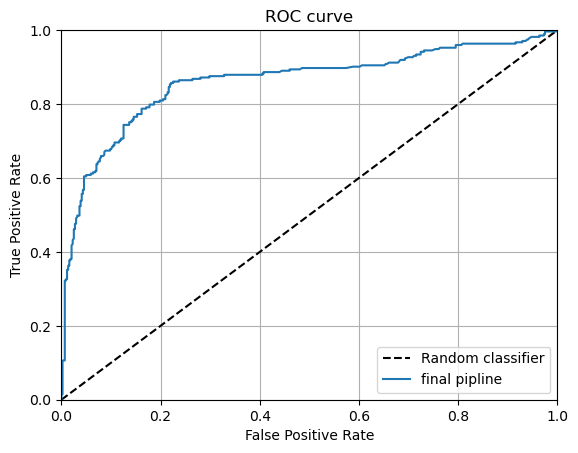

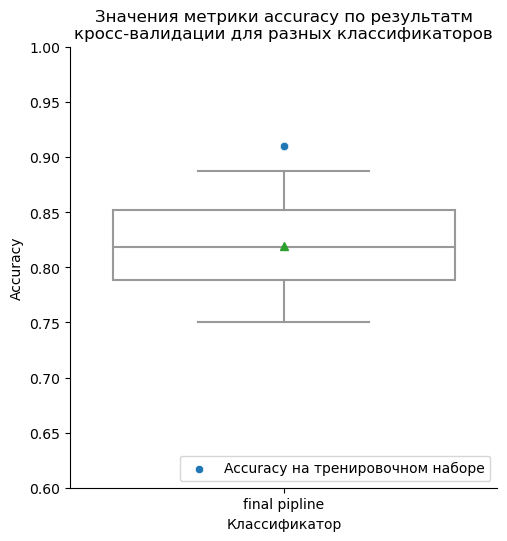

In [14]:
get_performance_of_one_model(model=pipe, 
                             X=X_train,
                             y=y_train, 
                             label='final pipline', 
                             scoring='accuracy', 
                             cv=CV, 
                             n_jobs=-1, 
                             method='predict_proba'
                            )

## Настройка гиперпараметров

Fitting 10 folds for each of 30 candidates, totalling 300 fits
0:	learn: 0.6931408	total: 880us	remaining: 37.9ms
1:	learn: 0.6931391	total: 1.59ms	remaining: 33.5ms
2:	learn: 0.6931349	total: 2.34ms	remaining: 31.9ms
3:	learn: 0.6931306	total: 2.74ms	remaining: 27.4ms
4:	learn: 0.6931267	total: 3.46ms	remaining: 27ms
5:	learn: 0.6931223	total: 4.21ms	remaining: 26.7ms
6:	learn: 0.6931189	total: 4.96ms	remaining: 26.2ms
7:	learn: 0.6931146	total: 5.65ms	remaining: 25.4ms
8:	learn: 0.6931121	total: 6.36ms	remaining: 24.7ms
9:	learn: 0.6931088	total: 6.76ms	remaining: 23ms
10:	learn: 0.6931035	total: 7.45ms	remaining: 22.4ms
11:	learn: 0.6931001	total: 8.12ms	remaining: 21.7ms
12:	learn: 0.6930974	total: 8.83ms	remaining: 21.1ms
13:	learn: 0.6930941	total: 9.63ms	remaining: 20.6ms
14:	learn: 0.6930896	total: 10.2ms	remaining: 19.7ms
15:	learn: 0.6930851	total: 10.9ms	remaining: 19.1ms
16:	learn: 0.6930822	total: 11.7ms	remaining: 18.6ms
17:	learn: 0.6930777	total: 12.5ms	remaining: 18.1m

,mean,median,min,max,results_on_train_set
accuracy,0.813243,0.823944,0.722222,0.875000,0.825843
f1,0.734309,0.752358,0.526316,0.842105,0.758755
roc_auc,0.864180,0.877492,0.773945,0.904882,0.876918


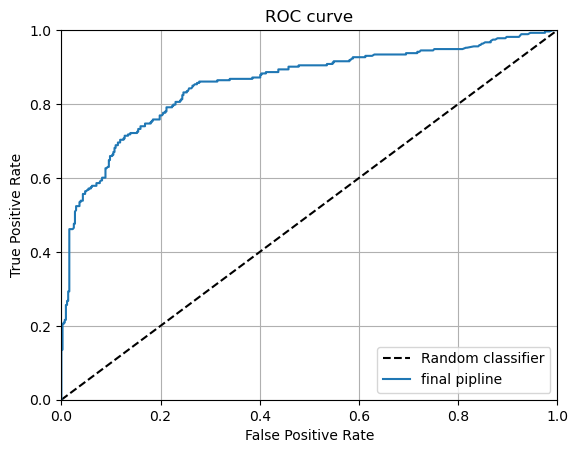

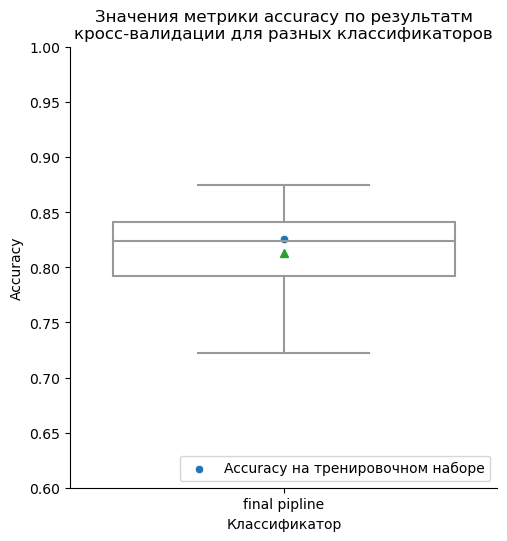

In [15]:
params = {    
    'col_selector__age_fare__discretizer__n_bins': [4],

    'classifier__learning_rate': [10**-5],

    'classifier__n_estimators': list(range(20, 50)),

#     'classifier__max_depth': [3, 4, 5, 6, 7],

#     'classifier__colsample_bytree': [0.4, 0.5, 0.6],
}


grid_search = GridSearchCV(estimator=pipe,
                           param_grid=params,
                           scoring='accuracy',
                           cv=CV,
                           n_jobs=-1,
                           verbose=1,
                          )

grid_search.fit(X=X_train, y=y_train)


print(grid_search.best_params_)


get_performance_of_one_model(model=grid_search.best_estimator_, 
                             X=X_train,
                             y=y_train, 
                             label='final pipline', 
                             scoring='accuracy', 
                             cv=CV, 
                             n_jobs=-1, 
                             method='predict_proba'
                            )

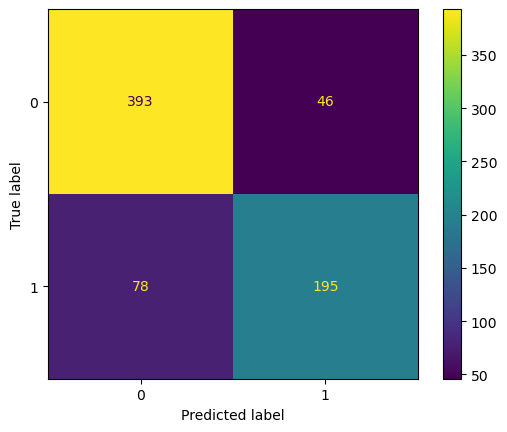

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, grid_search.best_estimator_.predict(X_train)),
                              display_labels=grid_search.best_estimator_.classes_
                             )
disp.plot()
plt.show()

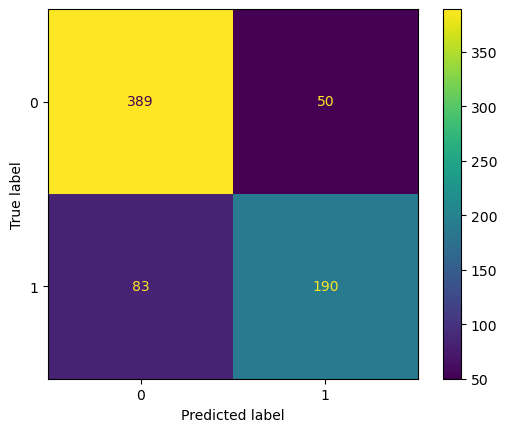

In [17]:
preds = cross_val_predict(estimator=grid_search.best_estimator_,
                          X=X_train,
                          y=y_train,
                          cv=CV,
                          n_jobs=-1
                         )

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, preds),
                              display_labels=grid_search.best_estimator_.classes_
                             )
disp.plot()
plt.show()

In [18]:
grid_search.best_estimator_.fit(X, y)

0:	learn: 0.6931409	total: 842us	remaining: 36.2ms
1:	learn: 0.6931390	total: 1.6ms	remaining: 33.6ms
2:	learn: 0.6931353	total: 2.31ms	remaining: 31.6ms
3:	learn: 0.6931313	total: 3.18ms	remaining: 31.8ms
4:	learn: 0.6931281	total: 3.74ms	remaining: 29.2ms
5:	learn: 0.6931229	total: 4.52ms	remaining: 28.6ms
6:	learn: 0.6931204	total: 5.22ms	remaining: 27.6ms
7:	learn: 0.6931159	total: 5.99ms	remaining: 26.9ms
8:	learn: 0.6931127	total: 6.75ms	remaining: 26.3ms
9:	learn: 0.6931080	total: 7.53ms	remaining: 25.6ms
10:	learn: 0.6931043	total: 8.32ms	remaining: 25ms
11:	learn: 0.6930998	total: 9.03ms	remaining: 24.1ms
12:	learn: 0.6930960	total: 9.7ms	remaining: 23.1ms
13:	learn: 0.6930927	total: 10.3ms	remaining: 22.1ms
14:	learn: 0.6930886	total: 11.1ms	remaining: 21.5ms
15:	learn: 0.6930851	total: 11.8ms	remaining: 20.7ms
16:	learn: 0.6930802	total: 12.5ms	remaining: 19.8ms
17:	learn: 0.6930763	total: 13ms	remaining: 18.8ms
18:	learn: 0.6930726	total: 13.8ms	remaining: 18.1ms
19:	learn:

Pipeline(steps=[('title_adder',
                 FunctionTransformer(func=<function add_title at 0x000002247410F130>)),
                ('family_adder',
                 FunctionTransformer(func=<function add_family at 0x000002247410F520>)),
                ('cabin_encoder',
                 FunctionTransformer(func=<function encode_cabin at 0x000002247410F880>)),
                ('ticket_encoder',
                 FunctionTransformer(func=<function encode_ticket at 0x000002247410...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=4)),
                                                                  ('encoder',
                                                                   TargetEncoder(cols=[0,
                                                                                       1]))]),
                                                  ['Age', 'Fare']),
                                                 ('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch',
                                                   'Family'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x00000224751DB970>)])

In [19]:
submission_X = pd.read_csv('../datasets/test.csv')
submission_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
submission_y = grid_search.best_estimator_.predict(submission_X)


submission = pd.DataFrame({'PassengerId': submission_X.PassengerId,
                           'Survived': submission_y,
                          }
                         )

submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [21]:
submission.to_csv('submission.csv', index=False)